In [34]:
import pandas as pd
import numpy as np
import copy
import locale
import math
import matplotlib.pyplot as plt
%matplotlib inline

from modules.files import *
from modules.data import *
from modules.enums import *

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

locale.setlocale( locale.LC_ALL, '')


#import_csv("Neighborhood_zhvi_uc_condo_tier_0.33_0.67_sm_sa_mon.csv")


'en_US.UTF-8'

In [3]:
#condo_data = import_csv("ingested_condo.csv")
#sfr_data = import_csv("ingested_singlefamilyresidence.csv")

In [3]:

#df2 = df1.pivot(index="Date", columns=["RegionName", "Housing Type"], values="% Change")
#df2 = df2.resample("Y").mean()
#df2.head()
#df2.plot(legend=False)

In [115]:
data = get_baseline_data(False, True)

df1 = data.copy(deep=True)

data = df1.reset_index("Housing Type") # remove multiindex to filter on housing type

data.head(10)

,Housing Type,City,State,ZHVI Start,Start Date,ZHVI End,End Date,ZHVI Min,ZHVI Max,Years Diff,% Per Year
RegionName,,,,,,,,,,,
90046,SingleFamilyResidence,Los Angeles,CA,172655.0,1996-01-31,2008581.0,2021-02-28,172655.0,2008581.0,25.1,10.270304
11201,SingleFamilyResidence,New York,NY,467848.0,1996-01-31,2966753.0,2021-02-28,467848.0,3049533.0,25.1,7.636416
11206,SingleFamilyResidence,New York,NY,180911.0,1996-01-31,1129253.0,2021-02-28,180694.0,1133223.0,25.1,7.568796
20002,SingleFamilyResidence,Washington,DC,146125.0,1996-01-31,802620.0,2021-02-28,135970.0,802620.0,25.1,7.022114
90046,Condo,Los Angeles,CA,146200.0,1996-01-31,786405.0,2021-02-28,137765.0,786405.0,25.1,6.932941
11201,Condo,New York,NY,168301.0,1996-01-31,841613.0,2021-02-28,164529.0,910432.0,25.1,6.622689
11226,SingleFamilyResidence,New York,NY,215405.0,1996-01-31,1075986.0,2021-02-28,211407.0,1075986.0,25.1,6.618044
10011,Condo,New York,NY,170150.0,1996-01-31,846310.0,2021-02-28,170150.0,1057748.0,25.1,6.599919
20009,SingleFamilyResidence,Washington,DC,185511.0,1996-01-31,917701.0,2021-02-28,179545.0,917701.0,25.1,6.576784


In [33]:
# summary table

default_groupby = ["Housing Type"]

summary_dataframe = pd.DataFrame()
summary_dataframe["% Per Year Min"] = data.groupby(default_groupby)["% Per Year"].min()
summary_dataframe["% Per Year Max"] = data.groupby(default_groupby)["% Per Year"].max()
summary_dataframe["% Per Year Avg"] = data.groupby(default_groupby)["% Per Year"].mean()
summary_dataframe["Years Diff Min"] = data.groupby(default_groupby)["Years Diff"].min()
summary_dataframe["Years Diff Max"] = data.groupby(default_groupby)["Years Diff"].max()
summary_dataframe["Years Diff Avg"] = data.groupby(default_groupby)["Years Diff"].mean()

summary_dataframe

,% Per Year Min,% Per Year Max,% Per Year Avg,Years Diff Min,Years Diff Max,Years Diff Avg
Housing Type,,,,,,
Condo,-0.283760,6.932941,3.912264,5.1,25.1,22.268
SingleFamilyResidence,-1.209351,10.270304,3.637877,11.7,25.1,22.898


<AxesSubplot:xlabel='ZHVI End', ylabel='% Per Year'>

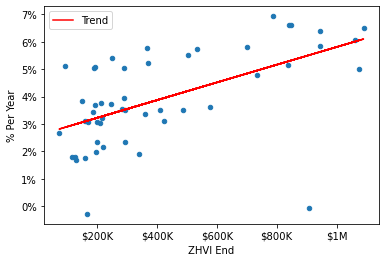

In [116]:
# highest condos mapped
condodata = data[data["Housing Type"]=="Condo"]

plot = condodata.plot(kind='scatter', x = 'ZHVI End', y = '% Per Year')

def format_func(value, tick_number):
    currency = locale.currency(value, grouping=True)
    currency_no_decimal = currency.split('.')[0]        
    if currency_no_decimal.find(',') != -1:
        currency_no_decimal = currency_no_decimal[:currency_no_decimal.index(',')]
        if currency.count(',') == 1:
            currency_no_decimal+="K"
        elif currency.count(',') == 2:
            currency_no_decimal+="M"
    return currency_no_decimal

def percent_formatter(value, tick_number):
    return "{}%".format(int(value))

plot.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plot.yaxis.set_major_formatter(plt.FuncFormatter(percent_formatter))


# https://towardsdatascience.com/regression-plots-with-pandas-and-numpy-faf2edbfad4f
d = np.polyfit(condodata['ZHVI End'],condodata['% Per Year'],1)
f = np.poly1d(d)

condodata.insert(6,'Trend',f(condodata['ZHVI End']))

condodata.plot(x='ZHVI End', y='Trend',color='Red',ax=plot)

<AxesSubplot:xlabel='ZHVI End', ylabel='% Per Year'>

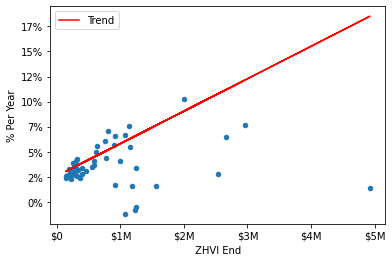

In [129]:
# highest sfr summary table
sfrdata = data[data["Housing Type"]=="SingleFamilyResidence"]

plot = sfrdata.plot(kind='scatter', x = 'ZHVI End', y = '% Per Year')

plot.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plot.yaxis.set_major_formatter(plt.FuncFormatter(percent_formatter))

d = np.polyfit(condodata['ZHVI End'],condodata['% Per Year'],1)
f = np.poly1d(d)

sfrdata.insert(len(sfrdata.columns),'Trend',f(sfrdata['ZHVI End']))

sfrdata.plot(x='ZHVI End', y='Trend',color='Red',ax=plot)

In [125]:
from datetime import datetime

datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

'2021-04-01T12:44:19'